In [2]:
import pandas as pd
import numpy as np;
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
# Players exp and level on the main game hiscores. Data scraped primarily 3/27/23-3/30/23. Lowest 450 ranks scraped 4/13/23.
# Wide format data. Gives experience and level for each skill for each player. If unranked, exp is -1 and level is 1. If 
# invention hasn't been unlocked, it's level is listed as 0.
currentexp = pd.read_csv('./FSW_Players_Current_Exp.csv',index_col=0)
currentlvl = pd.read_csv('./FSW_Players_Current_Level.csv',index_col=0)

# This has each player who was on the FSW hiscores at the end of FSW. The column 'Total Exp' is the total exp gained in FSW. 
# The column 'CurrentExp' is the exp scraped from the main hiscores. If the hiscores page for a particular player returns a 
# 404 error, CurrentExp is listed as 'Not on Hiscores'.
current_hiscores = pd.read_csv('./FSW_Players_CurrentHiscores_OnlyOverall_complete.csv',index_col=0)

In [4]:
print(current_hiscores.head)

<bound method NDFrame.head of        Unnamed: 0.1   Rank      Username  Total Level   Total Exp  \
0                 0      1     Mud Fresh         2898  3684066636   
1                 1      2       fsw pot         2898  3255763578   
2                 2      3     LoveDrunk         2898  2172584360   
3                 3      4       Andre 2         2898  1975645803   
4                 4      5  died2wallfsw         2898  1788407890   
...             ...    ...           ...          ...         ...   
58084            20  58085      Neo Odin           43        2196   
58085            21  58086         KLR04           43        2166   
58086            22  58087  Yeets Mcgee1           43        2162   
58087            23  58088    An FSW Alt           42        2463   
58088            24  58089        Xyrom0           42        2174   

            CurrentLvl       CurrentExp  
0                 2898       5599930079  
1                 2898       3260397578  
2              

## Intro

Fresh Start Worlds was marketed as a way to bring new and returning players to Runescape and give them a boost in progression to get them engaged with the game. It has been debated in the community how successful this was. I have thought that Fresh Start Worlds would mainly appeal to current players who wanted an accelerated game mode with a competition, but would not lead to a large number of players continuing on with their account. (This is mainly because that's how I approached FSW.)

In this notebook I'd like to adress the question "Was Fresh Start Worlds" successful. To be more specific, I would take FSW as a success if more than 5% of players that played during FSW continued to play in the main game. This number isn't based on anything any particular data. Since I expect that most players were running FSW as an alt that they planned to discard after the completion of the game mode, I would expect the overall number of players that continue to be low.

In [5]:
still_on_hiscores = current_hiscores[current_hiscores['CurrentExp']!='Not on Hiscores']
print(still_on_hiscores.head)

<bound method NDFrame.head of        Unnamed: 0.1   Rank      Username  Total Level   Total Exp CurrentLvl  \
0                 0      1     Mud Fresh         2898  3684066636       2898   
1                 1      2       fsw pot         2898  3255763578       2898   
2                 2      3     LoveDrunk         2898  2172584360       2898   
3                 3      4       Andre 2         2898  1975645803       2898   
4                 4      5  died2wallfsw         2898  1788407890       2898   
...             ...    ...           ...          ...         ...        ...   
58029         58029  58030     xxDravenx           45        2173        220   
58040             1  58041       Stelano           45        2154         45   
58041             2  58042    Screpulous           45        2154         45   
58042             3  58043      Stretzia           45        2154         45   
58046             7  58047     WibbieIII           44        2485         60   

       Cu

There are 21,048 players currently listed on the main game hiscores of the 58,089 players that were listed on the hiscores at the end of FSW. The players that are not listed on the hiscores could have changed their username, have been banned, or not show up on the hiscores for another reason. From poking around at some of the players who aren't on the hiscores, I think the third category of people is pretty large. There seem to be many low-level accounts that aren't on the main hiscores even though they had enough overall exp to be ranked. I'm guessing this is becuase they never logged into a main game server.

As people that have changed their username are likely still playing, but people that never logged into the main game server are certainly not still playing, the people who aren't on the hiscores introduce a huge uncertainty in the number of players that are still playing.

In [6]:
still_on_hiscores['GainedExp'] = still_on_hiscores['CurrentExp'].astype('int64')- still_on_hiscores['Total Exp'].astype('int64')

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
still_on_hiscores

,Unnamed: 0.1,Rank,Username,Total Level,Total Exp,CurrentLvl,CurrentExp,GainedExp
0,0,1,Mud Fresh,2898,3684066636,2898,5599930079,1915863443
1,1,2,fsw pot,2898,3255763578,2898,3260397578,4634000
2,2,3,LoveDrunk,2898,2172584360,2898,2172969875,385515
3,3,4,Andre 2,2898,1975645803,2898,2236245846,260600043
4,4,5,died2wallfsw,2898,1788407890,2898,1788412077,4187
...,...,...,...,...,...,...,...,...
58029,58029,58030,xxDravenx,45,2173,220,82689,80516
58040,1,58041,Stelano,45,2154,45,2154,0
58041,2,58042,Screpulous,45,2154,45,2154,0
58042,3,58043,Stretzia,45,2154,45,2154,0


In [8]:
still_on_hiscores[still_on_hiscores['GainedExp'] < 0]

,Unnamed: 0.1,Rank,Username,Total Level,Total Exp,CurrentLvl,CurrentExp,GainedExp
208,208,209,Esporta,2780,618467681,2699,432565869,-185901812
846,846,847,Reincamel,2561,383347604,2561,383281534,-66070
3216,3216,3217,sustime,2292,117798740,2292,117736224,-62516
4543,4543,4544,Oreithyia x,2195,183584413,1267,5411266,-178173147
6943,6943,6944,n0nameworks,2043,51885098,2043,51879867,-5231
8024,8024,8025,Tovernaaier,1985,209438733,1051,7676119,-201762614
8171,8171,8172,inanimatesun,1973,37739000,56,3385,-37735615
9665,9665,9666,Closner,1851,679404432,528,1341209,-678063223
11234,11234,11235,FSW_IS_SH1T,1741,47983450,1742,47949506,-33944
12074,12074,12075,PizelRs,1682,162802655,1648,148282859,-14519796


These 33 players have less total experience when scraped months after FSW than they did at the end of FSW. For the players with ~100 less exp, I have no idea what happened. For the two players at the bottom, it looks like they don't show up on the overall hiscores, but do show up in an invidual skill. I have no idea why that might happen. For the rest of the players, it looks like they transferred their FSW name onto a different account that had lower stats. 
Since there are few players overall that have negative gained experience, I'll drop them from the rest of the analysis.

In [9]:
still_on_hiscores = still_on_hiscores[still_on_hiscores['GainedExp'] >= 0]

### Retained Players Analysis

Looking at the first and last few rows of the dataframe with the gained exp, there are a couple things that jump out. At the bottom, there are 3 players with 0 gained exp. These players have clearly not been playing the game and shouldn't be included in the count of continuing players. Mud Fresh and Andre 2 have gained over 200m experience in their skills since the end of FSW, so they defintely do count as continuing players. fsw pot has gained 4.6m experience, but given they finished FSW with 3.2 billion experience, I think they probably used up some Treasure Hunter keys or played until their membership ran out, and then quit. The other 2 in the top 5 almost certainly shouldn't be considered continuing players, since their gained exp is very small for their overall exp. xxDravenX is an interesting case. They have gained much more experience since the end of FSW and increased their total level by a factor of ~5. They probably should count as a continuing player, even though their gained exp is less than LoveDrunk, who shouldn't be.

I will look at both the total Gained Exp and the ratio of Gained Exp to Total Exp at the end of FSW. The raw value of Gained Exp will be useful for players that are towards the top end of the hiscores, since they have skills at levels that give higher exp rates. 

(0.0, 500.0)

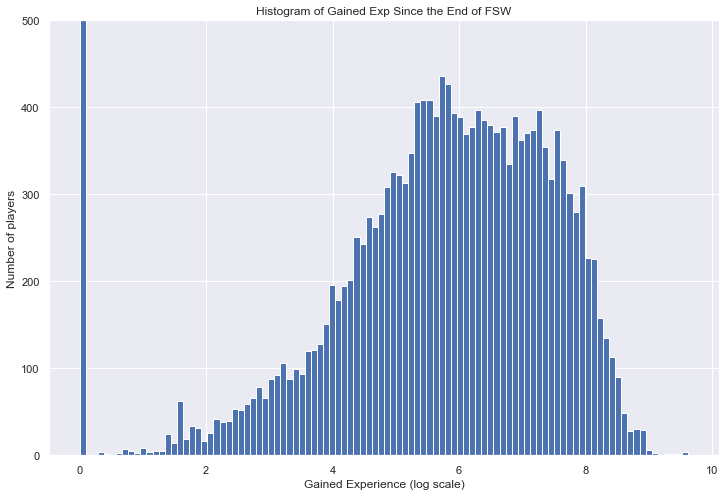

In [47]:
gained_fig = plt.figure(0,figsize = (12,8),facecolor = 'white')
gained_ax = gained_fig.add_subplot(111)
# There are a lot of people who didn't gain any exp. This causes an issue with the log, so add 1 to the gained exp.
# The x-axis is log because there is a long tail for players that gained 100's of million or over a billion experience.
gained_plot = plt.hist(np.log10(still_on_hiscores['GainedExp']+1),bins = 100)

plt.title('Histogram of Gained Exp Since the End of FSW')
plt.xlabel('Gained Experience (log scale)')
fig_ylabel = plt.ylabel('Number of players')
plt.ylim((0,500))

There are around 4,000 players that didn't gain any experience post FSW. That has been cropped out of the plot to allow the intesting part of the data to be easier to see.

In [11]:
# My ending rank and gained exp for reference. I didn't play much after the end of FSW other than to transfer
# my challenger halo, skill cape tokens, and skilling pet tokens to my ironman.
still_on_hiscores[still_on_hiscores['Username'] == 'Trevbrun720']

,Unnamed: 0.1,Rank,Username,Total Level,Total Exp,CurrentLvl,CurrentExp,GainedExp
1320,1320,1321,Trevbrun720,2488,335572086,2488,336090808,518722


In [12]:

for i in [0,1000, 100000, 1000000, 28000000,100000000]:
    temp = still_on_hiscores[still_on_hiscores['GainedExp'] > i]
    players = temp.shape[0]
    perc = players/current_hiscores.shape[0]*100
    print(f'There are {players:,} players who have gained more than {i:,} exp since the end of FSW. This is {perc:.1f}% of all FSW players.')

There are 17,078 players who have gained more than 0 exp since the end of FSW. This is 29.4% of all FSW players.
There are 16,289 players who have gained more than 1,000 exp since the end of FSW. This is 28.0% of all FSW players.
There are 12,518 players who have gained more than 100,000 exp since the end of FSW. This is 21.5% of all FSW players.
There are 8,529 players who have gained more than 1,000,000 exp since the end of FSW. This is 14.7% of all FSW players.
There are 2,901 players who have gained more than 28,000,000 exp since the end of FSW. This is 5.0% of all FSW players.
There are 1,070 players who have gained more than 100,000,000 exp since the end of FSW. This is 1.8% of all FSW players.


The top 5.0% of players gained more than 28 million exp since the end of FSW. Gaining this much experience doesn't seem to be something that a player would do if they were only transferring things off of the account to cash out for another account. By the threshold I set at the beginning, this would say that Fresh Start Worlds was successful.

Further, 14.7% of FSW players have gained an additional 1 million experience after the closing of FSW. This is higher than I would have expected. From this data, it's unclear how those players break down into new players and alt accounts, but either way this is more of an argument that FSW was successful. 

In [13]:
# Calculate how much experience players gained as a ratio of the experience they gained during FSW.
still_on_hiscores['ExpRatio'] = still_on_hiscores['GainedExp'].div(still_on_hiscores['Total Exp'].astype('int64'))

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
still_on_hiscores.loc[still_on_hiscores['ExpRatio'].idxmax(),:]

Unnamed: 0.1         55851
Rank                 55852
Username          Caraxses
Total Level             59
Total Exp             4067
CurrentLvl            2872
CurrentExp      2214882500
GainedExp       2214878433
ExpRatio            544598
Name: 55851, dtype: object

This is wild. This player only gained 4,067 in FSW but has gained over 2 billion exp since. I guess I need to cap the histogram at something more reasonable to be able to see everything.

There are 21015 players still on the hiscores.
There are 20164 players still on the hiscores with an Exp Ratio less than 5.


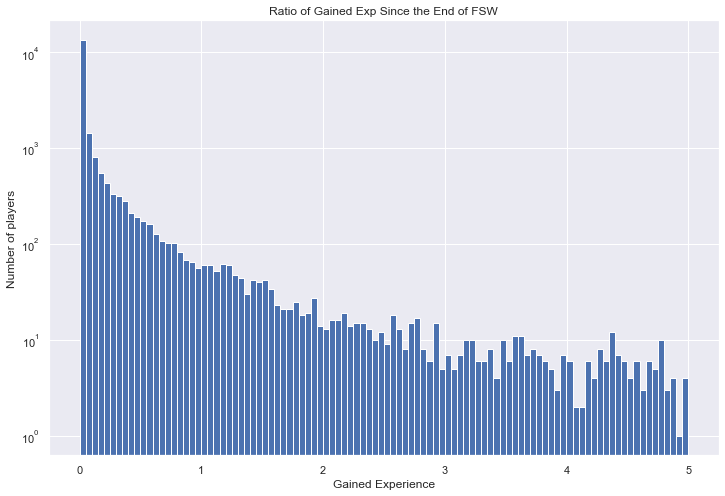

In [53]:
ratio_fig = plt.figure(1,figsize = (12,8),facecolor='white')
ratio_ax = ratio_fig.add_subplot(111)
# No log this time. Since the players that gained a lot of exp after FSW probably are the same as those who gained a lot during
# FSW we don't need to worry about the tail.
still_on_hiscores_reasonable = still_on_hiscores[still_on_hiscores['ExpRatio'] < 5]
print(f'There are {still_on_hiscores.shape[0]} players still on the hiscores.')
print(f'There are {still_on_hiscores_reasonable.shape[0]} players still on the hiscores with an Exp Ratio less than 5.')
gained_plot = plt.hist(still_on_hiscores_reasonable['ExpRatio'],bins = 100)

plt.title('Ratio of Gained Exp Since the End of FSW')
plt.xlabel('Gained Experience')
fig_ylabel = plt.ylabel('Number of players')
#plt.ylim((0,7000))
ratio_ax.set_yscale('log')
#plt.xlim((0,1))

This plot cuts off after an exp ratio of 5. There are around 850 players with a higher exp ratio, but they have been omitted to focus on the bulk of players.

In [54]:
for i in [0, .25, .5, .58, 1, 2, 5]:
    temp = still_on_hiscores[still_on_hiscores['ExpRatio'] > i]
    players = temp.shape[0]
    perc = players/current_hiscores.shape[0]*100
    print(f'There are {players:,} players who have gained more than {i:.2f}x exp since the end of FSW. This is {perc:.1f}% of all FSW players.')

There are 17,078 players who have gained more than 0.00x exp since the end of FSW. This is 29.4% of all FSW players.
There are 4,467 players who have gained more than 0.25x exp since the end of FSW. This is 7.7% of all FSW players.
There are 3,143 players who have gained more than 0.50x exp since the end of FSW. This is 5.4% of all FSW players.
There are 2,878 players who have gained more than 0.58x exp since the end of FSW. This is 5.0% of all FSW players.
There are 2,097 players who have gained more than 1.00x exp since the end of FSW. This is 3.6% of all FSW players.
There are 1,357 players who have gained more than 2.00x exp since the end of FSW. This is 2.3% of all FSW players.
There are 851 players who have gained more than 5.00x exp since the end of FSW. This is 1.5% of all FSW players.


The top 5% of players have gained at least 58% of their FSW exp since being transferred to the main game. I scraped the hiscores a little over two months after the end of FSW and FSW ran for about four months. If players were playing consistently for this whole time we would expect them to gain about 50% more exp. (This glosses over a ton of the nuance of how Runescape actually works, but to leading order seems reasonable.) 

Looking at the ratio of experience that the top 5% of players have earned, I would once again say that Fresh Start Worlds was successful.

### Clustering in the Hiscores

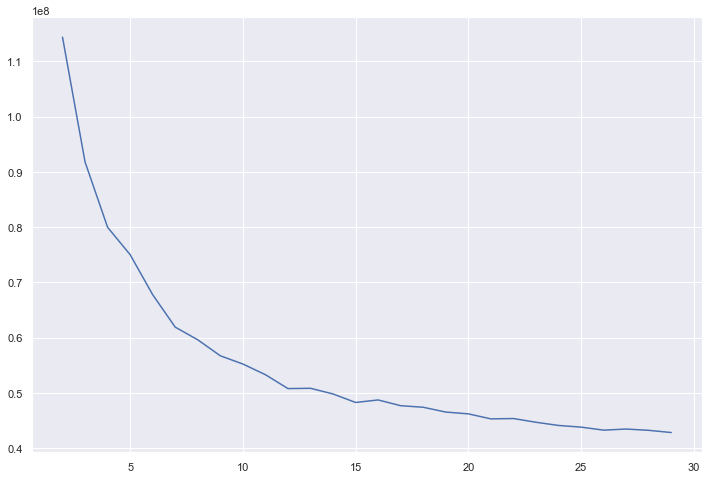

In [44]:
scores = []
for i in range(2,30):
    kmeans = KMeans(n_clusters=i, random_state=444,init='k-means++').fit(currentexp)
    score = sum(np.min(cdist(currentexp, kmeans.cluster_centers_,'euclidean'),axis=1))/currentexp.shape[0]
    scores.append(score)
    #print(f'Score was {score} for {i} clusters.')
    # TO-DO: Make this into a plot to figure out the right number of clusters. 
    # Then use those clusters and see if there's anything intersting
score_fig = plt.figure('score',figsize = (12,8),facecolor = 'white')
score_ax = score_fig.add_subplot(111)
score_plot = score_ax.plot(range(2,30), scores)

In [18]:
kmeans = KMeans(n_clusters=10, random_state=444,init='k-means++').fit(currentexp)

In [19]:
pca = PCA(n_components = 2)
pca_features = pca.fit_transform(currentexp)

In [20]:
pca_features

array([[-1.54432184e+08, -3.81190185e+06],
       [-7.79733241e+07,  3.29974402e+06],
       [ 2.81643151e+08, -1.16786767e+08],
       ...,
       [ 8.80488122e+07,  5.45500735e+06],
       [ 5.12537225e+08,  9.62686581e+07],
       [-1.54449605e+08, -3.80764074e+06]])

In [21]:
kmeans.predict(currentexp)

array([9, 1, 4, ..., 7, 0, 9])

No handles with labels found to put in legend.


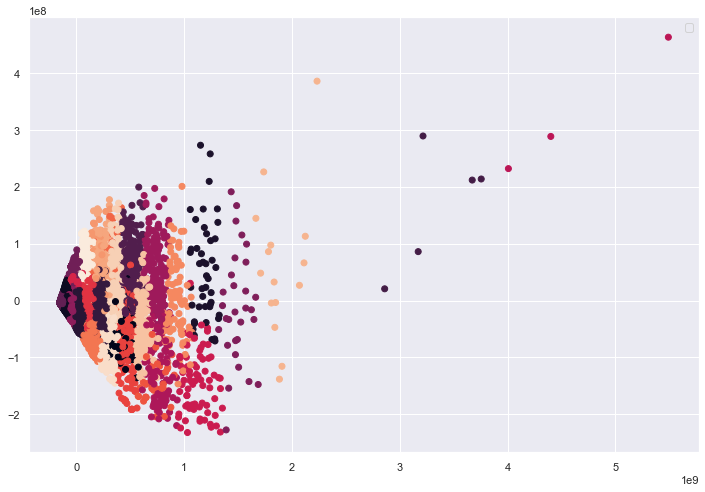

In [45]:
pca_fig = plt.figure('pca',figsize = (12,8),facecolor = 'white')
pca_ax = pca_fig.add_subplot(111)
pca_plot = pca_ax.scatter(pca_features[:,0],pca_features[:,1],c=kmeans.predict(currentexp))
pca_ax.legend()

In [23]:
pca_df = pd.DataFrame(pca_features, columns = ['pca1','pca2'])
pca_df['Cluster'] = kmeans.predict(currentexp)

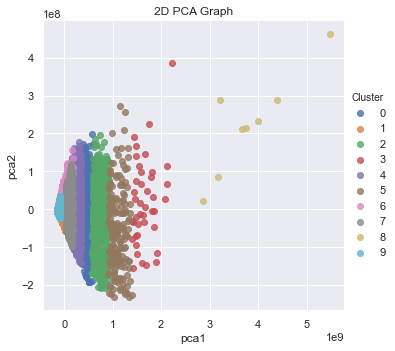

In [24]:
sns.set()
sns.lmplot(
    x = 'pca1',
    y = 'pca2',
    data = pca_df,
    hue = 'Cluster',
    fit_reg = False,
    legend = True
    )

plt.title('2D PCA Graph')
plt.show()

In [25]:
scaledfeatures = StandardScaler().fit_transform(currentexp)

In [26]:
pca_scaled = PCA(n_components = 2)
pca_features_scaled = pca_scaled.fit_transform(scaledfeatures)
pca_df_scaled = pd.DataFrame(pca_features_scaled, columns = ['pca1','pca2'])
pca_df_scaled['Cluster'] = kmeans.predict(currentexp)

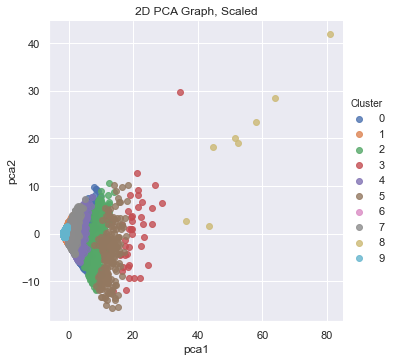

In [27]:
sns.set()
sns.lmplot(
    x = 'pca1',
    y = 'pca2',
    data = pca_df_scaled,
    hue = 'Cluster',
    fit_reg = False,
    legend = True
    )

plt.title('2D PCA Graph, Scaled')
plt.show()

In [28]:
kmeans = KMeans(n_clusters=10, random_state=333,init='k-means++').fit(currentexp)
kmeans_df = pd.DataFrame(kmeans.cluster_centers_)
hiscores_map = {0:'Overall', 1:'Attack', 2:'Defence', 3:'Strength', 4:'Constitution', 5:'Ranged', 6:'Prayer', 7:'Magic', 8:'Cooking', 9:'Woodcutting', 10:'Fletching', 11:'Fishing', 12:'Firemaking', 13:'Crafting', 14:'Smithing', 15:'Mining', 16:'Herblore', 17:'Agility', 18:'Thieving', 19:'Slayer', 20:'Farming', 21:'Runecrafting', 22:'Hunter', 23:'Construction', 24:'Summoning', 25:'Dungeoneering', 26:'Divination', 27:'Invention', 28:"Archaeology"}
kmeans_df.rename(columns = hiscores_map, inplace = True)
kmeans_df

,Overall,Attack,Defence,Strength,Constitution,Ranged,Prayer,Magic,Cooking,Woodcutting,...,Slayer,Farming,Runecrafting,Hunter,Construction,Summoning,Dungeoneering,Divination,Invention,Archaeology
0,1.868948e+07,5.421607e+05,1.736959e+06,4.654646e+05,1.848543e+06,8.631020e+05,3.750268e+05,2.432728e+06,2.890843e+05,5.031728e+05,...,5.027869e+05,2.852887e+05,3.713385e+05,2.934336e+05,2.282241e+05,1.662983e+05,2.574487e+05,8.147795e+05,1.088596e+05,3.791240e+05
1,2.536680e+08,8.815693e+06,2.200068e+07,8.998356e+06,2.387368e+07,1.210244e+07,6.866784e+06,2.262008e+07,3.169185e+06,4.983201e+06,...,1.226464e+07,5.949440e+06,2.635807e+06,7.455763e+06,3.647015e+06,5.355323e+06,7.480325e+06,6.735681e+06,8.319580e+06,1.425834e+07
2,8.783970e+08,5.014894e+07,9.541062e+07,5.026054e+07,1.124690e+08,4.658996e+07,1.667754e+07,8.796220e+07,6.859220e+06,8.255966e+06,...,5.178972e+07,2.004441e+07,5.716142e+06,1.784638e+07,7.189474e+06,1.543126e+07,2.188865e+07,1.269022e+07,6.046890e+07,4.468230e+07
3,4.183659e+08,1.489759e+07,3.879130e+07,1.567884e+07,4.209570e+07,2.150701e+07,9.275462e+06,3.826864e+07,4.472279e+06,6.278304e+06,...,2.409542e+07,9.291639e+06,3.881723e+06,1.303877e+07,5.156376e+06,8.156879e+06,9.672430e+06,9.435390e+06,2.133578e+07,2.424584e+07
4,1.181475e+08,4.977815e+06,1.103337e+07,4.749307e+06,1.242360e+07,6.634857e+06,3.000984e+06,1.170502e+07,1.660674e+06,3.194089e+06,...,3.948238e+06,2.414109e+06,1.540837e+06,2.731473e+06,1.579064e+06,1.772219e+06,2.383452e+06,4.757392e+06,1.801174e+06,6.411534e+06
5,3.923218e+09,1.694054e+08,1.904964e+08,1.548553e+08,2.000000e+08,1.849133e+08,1.316105e+08,1.943951e+08,9.988352e+07,1.008120e+08,...,1.720061e+08,1.529129e+08,1.370651e+08,1.185709e+08,1.091049e+08,1.323134e+08,1.444873e+08,1.181210e+08,2.000000e+08,1.462362e+08
6,6.141106e+08,2.273006e+07,6.270696e+07,2.397245e+07,6.745407e+07,2.983240e+07,1.295082e+07,6.187925e+07,6.451409e+06,6.814543e+06,...,4.167963e+07,1.338693e+07,5.764583e+06,1.488492e+07,7.047032e+06,1.006224e+07,1.331040e+07,1.089432e+07,3.951910e+07,3.725998e+07
7,1.228504e+09,8.924215e+07,1.288811e+08,1.004825e+08,1.558942e+08,8.730348e+07,2.425682e+07,1.242215e+08,9.240866e+06,1.015368e+07,...,7.123753e+07,2.599324e+07,8.796187e+06,2.341503e+07,9.523101e+06,2.605541e+07,2.976831e+07,1.257121e+07,7.089271e+07,4.993224e+07
8,1.776890e+09,9.343122e+07,1.367552e+08,9.939964e+07,1.599977e+08,9.349994e+07,4.501292e+07,1.305344e+08,2.141946e+07,2.164083e+07,...,1.087760e+08,7.661968e+07,2.050281e+07,5.954449e+07,2.847601e+07,2.229650e+07,6.663453e+07,2.877719e+07,1.059627e+08,8.702510e+07
9,1.572500e+08,1.383199e+06,4.511500e+06,1.259017e+06,4.896689e+06,2.230469e+06,9.359311e+05,5.795873e+06,9.240883e+05,1.149993e+06,...,1.497032e+06,1.025995e+06,5.119726e+05,2.374949e+06,6.222905e+05,4.349192e+05,6.914039e+05,3.124366e+06,4.807727e+05,3.549189e+06


In [29]:
kmeans_df['Label'] = kmeans_df.index
kmeans_melt = pd.melt(kmeans_df,id_vars = 'Label')
kmeans_melt.rename(columns = {'variable':'Skill','value':'Experience'},inplace = True)

counts = pd.DataFrame(kmeans.predict(currentexp),columns =['prediction'])['prediction'].value_counts()
print(counts)

0    10366
4     4565
1     2390
3     1303
9     1059
6      745
2      407
7      166
8       39
5        8
Name: prediction, dtype: int64


In [30]:
inverted_skillcape_colormap = {
    "Overall" : '#0000FF',
    "Agility" : "#bb3329",
    "Archaeology" : "#1f2024",
    "Attack" : "#eace14",
    "Constitution" : "#d53f34",
    "Construction" : "#c1992b",
    "Cooking" : "#961100",
    "Crafting" : "#cbc74b",
    "Defence" : "#dae5e5",
    "Divination" : "#2eb5b3",
    "Dungeoneering" : "#cacbd3",
    "Farming" : "#9bc074",
    "Firemaking" : "#c4b94b",
    "Fishing" : "#ccbf4f",
    "Fletching" : "#e8ba13",
    "Herblore" : "#d8d110",
    "Hunter" : "#342100",
    "Invention" : "#2fa6f3",
    "Magic" : "#3640ce",
    "Mining" : "#63cae8",
    "Prayer" : "#f6f019",
    "Ranged" : "#bd6c0b",
    "Runecrafting" : "#eddd16",
    "Slayer" : "#941200",
    "Smithing" : "#cec46e",
    "Strength" : "#b61c0c",
    "Summoning" : "#bdb146",
    "Thieving" : "#202024",
    "Woodcutting" : "#309154"
} 

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


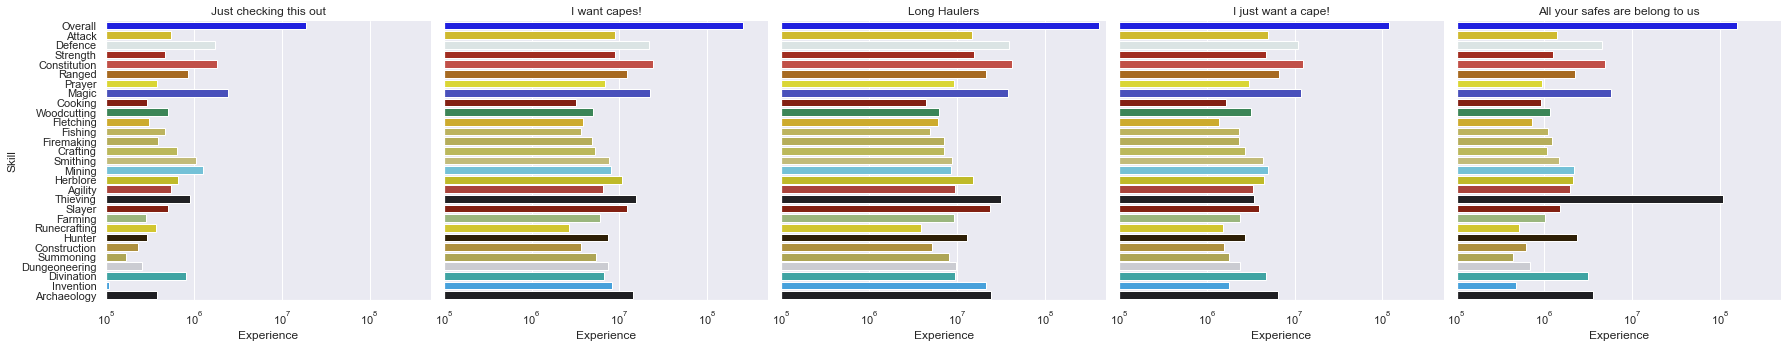

In [42]:
plotting_data = kmeans_melt[kmeans_melt['Label'].isin(counts.index[0:5])]
plotting_data['Label'] = plotting_data['Label'].replace(group_names_map)
cluster_plot = sns.catplot("Experience","Skill",col='Label',data=plotting_data,
                            kind='bar',orient="h",log=True, 
                            palette = inverted_skillcape_colormap)
plt.xlim(100000,500000000)
cluster_plot.set_titles('{col_name}')


In [32]:
players_cluster = kmeans.predict(currentexp)
player_group = pd.DataFrame(players_cluster, index = currentexp.index,columns = ['Group'])
group_names_map = {0:"Just checking this out",1:"I want capes!",3:"Long Haulers",
                   4:"I just want a cape!",9:"All your safes are belong to us",2:2,5:5,6:6,7:7,8:8}
player_group['Group'] = player_group['Group'].map(group_names_map, na_action = 'ignore')
player_group.to_csv('./FSW_Player_Cluster_Labels.csv')

In [33]:
# See which group I'm in.
player_group.at['Trevbrun720','Group']

'I want capes!'

I spent a lot of time trying to get capes, so ya, this seems to track.